In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
# import numpy as np
import cupy as np


## Model definition

In [2]:
olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
olfactory_data = np.array(olfactory_data)

In [3]:
# olfactory_data = pd.read_csv('./Data/statistics_nose_5e6.dat', sep=' ', skiprows=[0], header=None).values.T
# olfactory_data = np.array(olfactory_data[:320,:])

In [4]:
# Model size
# env_shape = (280, 1225)
# env_shape = (70,153)
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (35, 153)
State count: 5355


In [5]:
# goal state
olfactory_data[17,0]

array(0.99884615)

In [6]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [7]:
# states
state_grid = []

# Rewards
# rewards = np.zeros((state_count, 4, state_count,2))
# rewards[:,:,id_from_pos(17,0),:] = 1

# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

observations = np.zeros((state_count, 4, 2))
observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
observations[:,:,1] = (1 - observations[:,:,0])

# Transitions and state labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [8]:
import numpy
row_w = env_shape[1]

reachable_states = numpy.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

In [9]:
# Reward function
def reward_func(s,a,sn,o):
    # return np.where(sn == (175*env_shape[1]), 1.0, 0.0)
    return np.where(sn == (17*env_shape[1]), 1.0, 0.0)

In [10]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[09/26/2023, 19:40:18] Instantiation of MDP Model:
[09/26/2023, 19:40:18] - 5355 states
[09/26/2023, 19:40:18] - 4 actions
[09/26/2023, 19:40:18] - At most 1 reachable states per state-action pair
[09/26/2023, 19:40:18] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[09/26/2023, 19:40:18]     > Done in 0.000s
[09/26/2023, 19:40:18] - Generating start probabilities table
[09/26/2023, 19:40:18] - Starting computation of reachable state probabilities from transition data
[09/26/2023, 19:40:18]     > Done in 0.000s
[09/26/2023, 19:40:18] POMDP particular parameters:
[09/26/2023, 19:40:18] - 2 observations
[09/26/2023, 19:40:18] - Starting of transitional observations for reachable states table
[09/26/2023, 19:40:18]     > Done in 0.004s
[09/26/2023, 19:40:18] - Starting generation of expected rewards table
[09/26/2023, 19:40

## VI Solve

In [11]:
from src.mdp import VI_Solver

In [12]:
solver = VI_Solver()

In [13]:
solution, history = solver.solve(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not ndarray

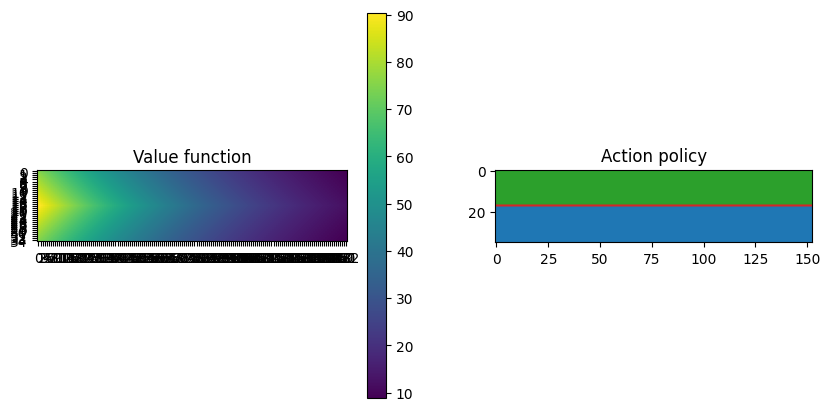

In [82]:
solution.plot()

## FSVI

In [15]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [16]:
# a_star = np.argmax(solution.alpha_vector_array[:,s])
# chosen_r_state = np.random.multinomial(n=1, pvals=model.reachable_probabilities[s,a_star])[0]
# s_p = model.reachable_states[s,a_star,chosen_r_state]
# np.random.multinomial(n=1, pvals=model.observation_table[s_p,a_star])

In [17]:
fsvi_solution, hist = fsvi_solver.solve(model,100,300,solution)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

skip


In [74]:
b_counts = [len(bs.belief_list) for bs in hist.belief_sets]

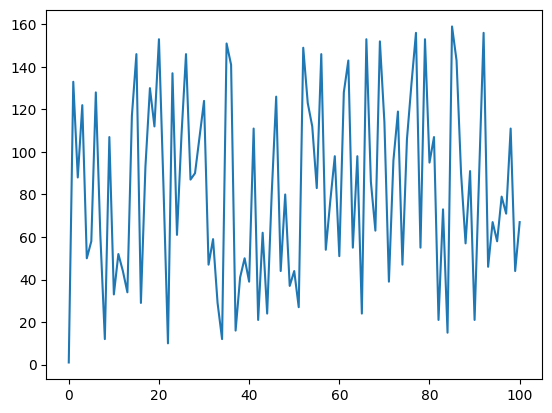

In [75]:
plt.plot(numpy.arange(len(b_counts)), b_counts)

In [76]:
alpha_counts = [len(vf) for vf in hist.value_functions]

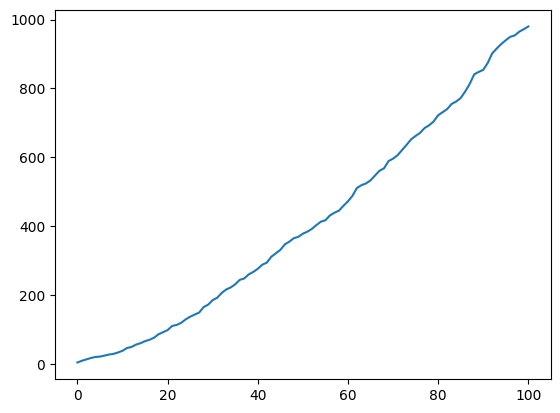

In [77]:
plt.plot(numpy.arange(len(alpha_counts)), alpha_counts)

In [79]:
moving_b_counts = numpy.cumsum(b_counts)

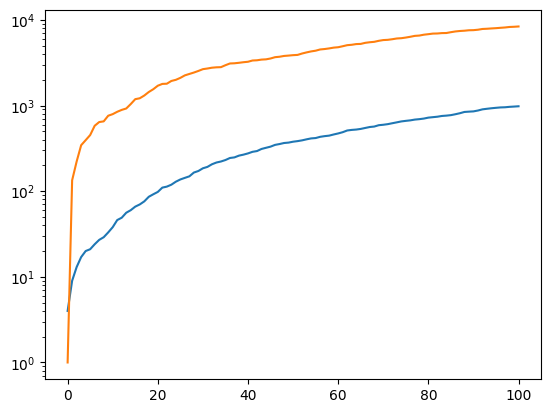

In [81]:
plt.plot(numpy.arange(len(alpha_counts)), alpha_counts)
plt.plot(numpy.arange(len(alpha_counts)), moving_b_counts)
plt.yscale("log")
plt.show()

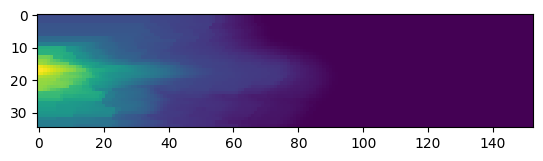

In [18]:
res = np.asnumpy(fsvi_solution.alpha_vector_array)
plt.imshow(numpy.max(res, axis=0).reshape(env_shape))

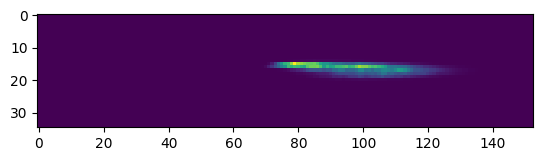

In [103]:
bs = hist.belief_sets[-1]
plt.imshow(np.asnumpy(bs.belief_list[0].grid_values))

In [109]:
changes = []
b = Belief(model)
old_max_val_per_belief = np.max(np.matmul(b.values.reshape((1,model.state_count)), hist.value_functions[0].alpha_vector_array.T), axis=1)
for vf in tqdm(hist.value_functions[1:]):
    max_val_per_belief = np.max(np.matmul(b.values.reshape((1,model.state_count)), vf.alpha_vector_array.T), axis=1)
    max_change = np.max(np.abs(max_val_per_belief - old_max_val_per_belief))
    old_max_val_per_belief = max_val_per_belief
    changes.append(float(max_change))

100%|██████████| 100/100 [00:00<00:00, 245.22it/s]


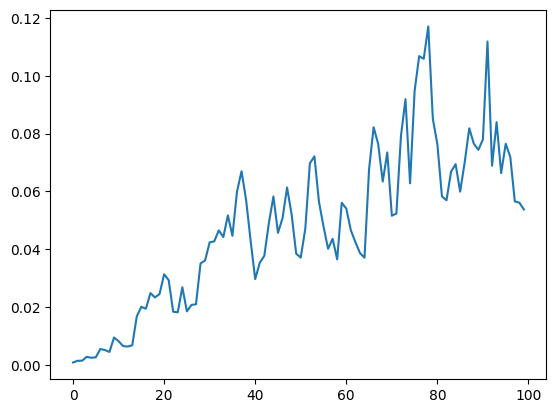

In [110]:
plt.plot(numpy.arange(len(changes)), changes)

In [27]:
len(fsvi_solution.alpha_vector_list)

980

In [68]:
from tqdm import tqdm
from scipy.optimize import milp, LinearConstraint

alpha_set = fsvi_solution.alpha_vector_list
pruned_alpha_set = []

for i, av in tqdm(enumerate(alpha_set)):
    alpha_vect = np.asnumpy(av.values)
    
    oa = alpha_set[:i] + alpha_set[(i+1):]
    other_alphas = [np.asnumpy(a.values) for a in oa]

    # Objective function
    c = numpy.concatenate([numpy.array([1]), -1*alpha_vect])

    # Alpha vector contraints
    other_count = len(other_alphas)
    A = numpy.c_[numpy.ones(other_count), numpy.multiply(numpy.array(other_alphas), -1)]
    # b_l = np.zeros(other_count)
    # b_u = np.full_like(b_l, np.inf)
    alpha_constraints = LinearConstraint(A, 0, numpy.inf)

    # Constraints that sum of beliefs is 1
    belief_constraint = LinearConstraint(numpy.array([0] + ([1]*model.state_count)), 1, 1)

    # Solve problem
    res = milp(c=c, constraints=[alpha_constraints, belief_constraint])

    # Check if dominated
    is_dominated = (res.x[0] - numpy.dot(res.x[1:], alpha_vect)) >= 0
    if is_dominated:
        print(alpha_vect)
        print(' -> Dominated\n')
    else:
        pruned_alpha_set.append(alpha_vect)

1it [00:00,  1.34it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



2it [00:01,  1.36it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



3it [00:02,  1.39it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



4it [00:02,  1.37it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



5it [00:03,  1.39it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



6it [00:04,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



7it [00:05,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



8it [00:05,  1.38it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



9it [00:06,  1.38it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



10it [00:07,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



11it [00:07,  1.41it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



12it [00:08,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



13it [00:09,  1.41it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



14it [00:10,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



15it [00:10,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



16it [00:11,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



17it [00:12,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



18it [00:12,  1.40it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



19it [00:13,  1.41it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



20it [00:14,  1.43it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



21it [00:14,  1.43it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



22it [00:15,  1.44it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



23it [00:16,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



24it [00:17,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



25it [00:17,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



26it [00:18,  1.43it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



27it [00:19,  1.44it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



28it [00:19,  1.45it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



29it [00:20,  1.44it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



30it [00:21,  1.43it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



31it [00:21,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



32it [00:22,  1.42it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



33it [00:23,  1.37it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



34it [00:24,  1.31it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



35it [00:25,  1.27it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



36it [00:25,  1.25it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



37it [00:26,  1.25it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



38it [00:27,  1.23it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



39it [00:28,  1.23it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



40it [00:29,  1.23it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



41it [00:30,  1.24it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



42it [00:30,  1.23it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



43it [00:31,  1.19it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



44it [00:32,  1.15it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



45it [00:33,  1.14it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



46it [00:34,  1.16it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



47it [00:35,  1.15it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



48it [00:36,  1.11it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



49it [00:37,  1.08it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



50it [00:38,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



51it [00:39,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



52it [00:40,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



53it [00:41,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



54it [00:42,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



55it [00:43,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



56it [00:44,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



57it [00:45,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



58it [00:46,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



59it [00:47,  1.10it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



60it [00:47,  1.12it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



61it [00:48,  1.13it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



62it [00:49,  1.13it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



63it [00:50,  1.14it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



64it [00:51,  1.16it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



65it [00:52,  1.10it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



66it [00:53,  1.11it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



67it [00:54,  1.13it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



68it [00:54,  1.14it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



69it [00:55,  1.13it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



70it [00:56,  1.10it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



71it [00:57,  1.09it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



72it [00:58,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



73it [00:59,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



74it [01:00,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



75it [01:01,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



76it [01:02,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



77it [01:03,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



78it [01:04,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



79it [01:05,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



80it [01:06,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



81it [01:07,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



82it [01:08,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



83it [01:09,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



84it [01:10,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



85it [01:11,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



86it [01:12,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



87it [01:13,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



88it [01:14,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



89it [01:15,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



90it [01:16,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



91it [01:17,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



92it [01:18,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



93it [01:19,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



94it [01:20,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



95it [01:21,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



96it [01:22,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



97it [01:23,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



98it [01:24,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



99it [01:24,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



100it [01:25,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



101it [01:26,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



102it [01:27,  1.08it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



103it [01:28,  1.09it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



104it [01:29,  1.08it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



105it [01:30,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



106it [01:31,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



107it [01:32,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



108it [01:33,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



109it [01:34,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



110it [01:35,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



111it [01:36,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



112it [01:37,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



113it [01:38,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



114it [01:39,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



115it [01:40,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



116it [01:40,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



117it [01:41,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



118it [01:43,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



119it [01:43,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



120it [01:44,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



121it [01:45,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



122it [01:46,  1.08it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



123it [01:47,  1.11it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



124it [01:48,  1.13it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



125it [01:49,  1.14it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



126it [01:50,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



127it [01:51,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



128it [01:52,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



129it [01:53,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



130it [01:54,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



131it [01:55,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



132it [01:56,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



133it [01:57,  1.00it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



134it [01:58,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



135it [01:59,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



136it [02:00,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



137it [02:01,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



138it [02:02,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



139it [02:03,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



140it [02:04,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



141it [02:05,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



142it [02:06,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



143it [02:07,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



144it [02:08,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



145it [02:09,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



146it [02:10,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



147it [02:11,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



148it [02:12,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



149it [02:13,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



150it [02:14,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



151it [02:15,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



152it [02:16,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



153it [02:18,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



154it [02:19,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



155it [02:20,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



156it [02:21,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



157it [02:22,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



158it [02:23,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



159it [02:24,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



160it [02:25,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



161it [02:26,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



162it [02:27,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



163it [02:28,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



164it [02:29,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



165it [02:30,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



166it [02:31,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



167it [02:32,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



168it [02:33,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



169it [02:34,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



170it [02:35,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



171it [02:36,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



172it [02:37,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



173it [02:38,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



174it [02:39,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



175it [02:40,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



176it [02:41,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



177it [02:42,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



178it [02:43,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



179it [02:45,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



180it [02:46,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



181it [02:47,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



182it [02:47,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



183it [02:48,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



184it [02:49,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



185it [02:50,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



186it [02:51,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



187it [02:52,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



188it [02:53,  1.08it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



189it [02:54,  1.08it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



190it [02:55,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



191it [02:56,  1.00s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



192it [02:57,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



193it [02:58,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



194it [02:59,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



195it [03:00,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



196it [03:02,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



197it [03:03,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



198it [03:04,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



199it [03:05,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



200it [03:06,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



201it [03:07,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



202it [03:08,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



203it [03:09,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



204it [03:10,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



205it [03:11,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



206it [03:12,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



207it [03:13,  1.00it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



208it [03:14,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



209it [03:15,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



210it [03:16,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



211it [03:17,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



212it [03:18,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



213it [03:19,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



214it [03:20,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



215it [03:21,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



216it [03:21,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



217it [03:23,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



218it [03:23,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



219it [03:24,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



220it [03:25,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



221it [03:26,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



222it [03:27,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



223it [03:28,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



224it [03:29,  1.07it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



225it [03:30,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



226it [03:31,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



227it [03:32,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



228it [03:33,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



229it [03:34,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



230it [03:35,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



231it [03:36,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



232it [03:37,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



233it [03:38,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



234it [03:39,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



235it [03:40,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



236it [03:41,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



237it [03:42,  1.00it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



238it [03:43,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



239it [03:44,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



240it [03:45,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



241it [03:47,  1.36s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



242it [03:48,  1.25s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



243it [03:49,  1.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



244it [03:50,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



245it [03:51,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



246it [03:52,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



247it [03:53,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



248it [03:54,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



249it [03:55,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



250it [03:56,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



251it [03:57,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



252it [03:58,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



253it [03:59,  1.03it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



254it [04:00,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



255it [04:01,  1.06it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



256it [04:02,  1.05it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



257it [04:03,  1.04it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



258it [04:04,  1.00s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



259it [04:05,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



260it [04:06,  1.02it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



261it [04:07,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



262it [04:08,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



263it [04:09,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



264it [04:10,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



265it [04:11,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



266it [04:12,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



267it [04:13,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



268it [04:14,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



269it [04:15,  1.00it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



270it [04:16,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



271it [04:17,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



272it [04:18,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



273it [04:19,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



274it [04:20,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



275it [04:21,  1.01it/s]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



276it [04:22,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



277it [04:23,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



278it [04:24,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



279it [04:25,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



280it [04:26,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



281it [04:28,  1.13s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



282it [04:29,  1.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



283it [04:30,  1.13s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



284it [04:31,  1.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



285it [04:32,  1.13s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



286it [04:34,  1.20s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



287it [04:35,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



288it [04:36,  1.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



289it [04:37,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



290it [04:38,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



291it [04:39,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



292it [04:40,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



293it [04:41,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



294it [04:42,  1.13s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



295it [04:43,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



296it [04:44,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



297it [04:45,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



298it [04:46,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



299it [04:47,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



300it [15:42, 197.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



301it [15:43, 138.31s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



302it [15:44, 97.10s/it] 

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



303it [15:45, 68.25s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



304it [15:46, 48.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



305it [15:47, 33.90s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



306it [15:48, 24.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



307it [15:49, 17.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



308it [15:50, 12.22s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



309it [15:51,  8.85s/it]

[0.64910263 0.64910263 0.64910263 ... 0.         0.         0.        ]
 -> Dominated



310it [15:52,  6.52s/it]

[0.64910263 0.64910263 0.64910263 ... 0.         0.         0.        ]
 -> Dominated



311it [15:53,  4.87s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



312it [15:54,  3.72s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



313it [15:55,  2.90s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



314it [15:56,  2.31s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



315it [15:57,  1.91s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



316it [15:58,  1.64s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



317it [15:59,  1.48s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



318it [16:01,  1.59s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



319it [16:03,  1.84s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



320it [16:04,  1.62s/it]

[0.6426116 0.6426116 0.6426116 ... 0.        0.        0.       ]
 -> Dominated



321it [16:05,  1.45s/it]

[0.6426116 0.6426116 0.6426116 ... 0.        0.        0.       ]
 -> Dominated



322it [16:06,  1.29s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



323it [16:07,  1.19s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



324it [16:08,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



325it [16:09,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



326it [16:10,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



327it [16:11,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



328it [16:12,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



329it [16:13,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



330it [16:14,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



331it [16:15,  1.02s/it]

[0.63618549 0.63618549 0.63618549 ... 0.         0.         0.        ]
 -> Dominated



332it [16:16,  1.00s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



333it [16:17,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



334it [16:18,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



335it [16:19,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



336it [16:20,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



337it [16:21,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



338it [16:22,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



339it [16:24,  1.21s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



340it [16:25,  1.20s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



341it [16:26,  1.24s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



342it [16:27,  1.18s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



343it [16:28,  1.13s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



344it [16:30,  1.17s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



345it [16:31,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



346it [16:32,  1.12s/it]

[1.2652824 1.2652824 1.2652824 ... 0.        0.        0.       ]
 -> Dominated



347it [16:33,  1.14s/it]

[0.62982363 0.62982363 0.62982363 ... 0.         0.         0.        ]
 -> Dominated



348it [16:34,  1.15s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



349it [16:35,  1.15s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



350it [16:36,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



351it [16:37,  1.12s/it]

[0.62352539 0.62352539 0.62352539 ... 0.         0.         0.        ]
 -> Dominated



352it [16:38,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



353it [16:41,  1.42s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



354it [16:42,  1.36s/it]

[1.25262957 1.25262957 1.25262957 ... 0.         0.         0.        ]
 -> Dominated



355it [16:43,  1.27s/it]

[1.25262957 1.25262957 1.25262957 ... 0.         0.         0.        ]
 -> Dominated



356it [16:44,  1.17s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



357it [16:45,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



358it [16:46,  1.11s/it]

[0.62352539 0.62352539 0.62352539 ... 0.         0.         0.        ]
 -> Dominated



359it [16:47,  1.09s/it]

[0.61729014 0.61729014 0.61729014 ... 0.         0.         0.        ]
 -> Dominated



360it [16:48,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



361it [16:49,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



362it [16:51,  1.32s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



363it [16:52,  1.30s/it]

[1.24010328 1.24010328 1.24010328 ... 0.         0.         0.        ]
 -> Dominated



364it [16:53,  1.25s/it]

[1.24010328 1.24010328 1.24010328 ... 0.         0.         0.        ]
 -> Dominated



365it [16:54,  1.19s/it]

[1.24010328 1.24010328 1.24010328 ... 0.         0.         0.        ]
 -> Dominated



366it [16:55,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



367it [16:56,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



368it [16:58,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



369it [16:59,  1.13s/it]

[1.22770225 1.22770225 1.22770225 ... 0.         0.         0.        ]
 -> Dominated



370it [17:00,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



371it [17:01,  1.06s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



372it [17:02,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



373it [17:03,  1.04s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



374it [17:04,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



375it [17:05,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



376it [17:06,  1.17s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



377it [17:07,  1.14s/it]

[1.21542522 1.21542522 1.21542522 ... 0.         0.         0.        ]
 -> Dominated



378it [17:08,  1.11s/it]

[1.21542522 1.21542522 1.21542522 ... 0.         0.         0.        ]
 -> Dominated



379it [17:09,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



380it [17:10,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



381it [17:11,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



382it [17:12,  1.02s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



383it [17:13,  1.01s/it]

[2.43098027 2.43098027 2.43098027 ... 0.         0.         0.        ]
 -> Dominated



384it [17:15,  1.10s/it]

[1.20327097 1.20327097 1.20327097 ... 0.         0.         0.        ]
 -> Dominated



385it [17:16,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



386it [17:17,  1.05s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



387it [17:18,  1.03s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



388it [17:19,  1.04s/it]

[1.19123826 1.19123826 1.19123826 ... 0.         0.         0.        ]
 -> Dominated



389it [17:20,  1.06s/it]

[1.19123826 1.19123826 1.19123826 ... 0.         0.         0.        ]
 -> Dominated



392it [17:23,  1.03s/it]

[2.40667046 2.40667046 2.40667046 ... 0.         0.         0.        ]
 -> Dominated



393it [17:24,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



394it [17:25,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



395it [17:26,  1.01s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



396it [17:27,  1.11s/it]

[1.21542522 1.21542522 1.21542522 ... 0.         0.         0.        ]
 -> Dominated



397it [17:28,  1.11s/it]

[1.19123826 1.19123826 1.19123826 ... 0.         0.         0.        ]
 -> Dominated



398it [17:29,  1.10s/it]

[1.17932588 1.17932588 1.17932588 ... 0.         0.         0.        ]
 -> Dominated



399it [17:30,  1.10s/it]

[2.38260376 2.38260376 2.38260376 ... 0.         0.         0.        ]
 -> Dominated



400it [17:32,  1.33s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



404it [17:37,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



405it [17:38,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



406it [17:39,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



407it [17:40,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



408it [17:41,  1.09s/it]

[1.17932588 1.17932588 1.17932588 ... 0.         0.         0.        ]
 -> Dominated



410it [17:44,  1.41s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



414it [17:49,  1.18s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



415it [17:50,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



416it [17:51,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



418it [17:53,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



419it [17:54,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



420it [17:56,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



421it [17:57,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



422it [17:58,  1.07s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



423it [17:59,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



424it [18:00,  1.13s/it]

[1.16753262 1.16753262 1.16753262 ... 0.         0.         0.        ]
 -> Dominated



425it [18:01,  1.22s/it]

[1.16753262 1.16753262 1.16753262 ... 0.         0.         0.        ]
 -> Dominated



426it [18:03,  1.19s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



427it [18:05,  1.49s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



428it [18:08,  1.93s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



432it [18:13,  1.36s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



433it [18:14,  1.26s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



434it [18:15,  1.20s/it]

[1.19123826 1.19123826 1.19123826 ... 0.         0.         0.        ]
 -> Dominated



440it [18:23,  1.23s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



441it [18:24,  1.18s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



442it [18:25,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



443it [18:26,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



446it [18:30,  1.23s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



447it [18:31,  1.22s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



448it [18:32,  1.19s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



449it [18:33,  1.15s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



450it [18:34,  1.15s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



451it [18:35,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



453it [18:38,  1.20s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



457it [18:43,  1.22s/it]

[1.15585729 1.15585729 1.15585729 ... 0.         0.         0.        ]
 -> Dominated



460it [18:46,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



461it [18:47,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



462it [18:48,  1.15s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



463it [18:50,  1.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



468it [18:57,  1.58s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



473it [19:06,  1.53s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



474it [19:07,  1.44s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



475it [19:08,  1.38s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



476it [19:09,  1.29s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



477it [19:10,  1.27s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



484it [19:20,  1.41s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



485it [19:23,  1.80s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



489it [19:28,  1.38s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



490it [19:29,  1.30s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



491it [19:30,  1.23s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



492it [19:31,  1.17s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



493it [19:32,  1.16s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



497it [19:37,  1.09s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



498it [19:38,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



499it [19:39,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



500it [19:40,  1.08s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



501it [19:41,  1.10s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



503it [19:43,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



507it [19:48,  1.14s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



512it [19:54,  1.12s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



513it [19:55,  1.11s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



520it [20:05,  1.35s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



522it [20:07,  1.24s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



531it [20:19,  1.38s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



540it [20:31,  1.34s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



545it [20:38,  1.31s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



558it [20:56,  1.29s/it]

[0. 0. 0. ... 0. 0. 0.]
 -> Dominated



980it [35:18,  2.16s/it]


In [69]:
len(pruned_alpha_set)

515

In [70]:
numpy.array(pruned_alpha_set)

array([[4.2745327 , 4.2745327 , 4.2745327 , ..., 0.        , 0.        ,
        0.        ],
       [4.2745327 , 4.2745327 , 4.2745327 , ..., 0.        , 0.        ,
        0.        ],
       [4.23178738, 4.23178738, 4.23178738, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.90643851, 3.90643851, 3.90643851, ..., 0.        , 0.        ,
        0.        ],
       [3.90643851, 3.90643851, 3.90643851, ..., 0.        , 0.        ,
        0.        ],
       [3.90643851, 3.90643851, 3.90643851, ..., 0.        , 0.        ,
        0.        ]])

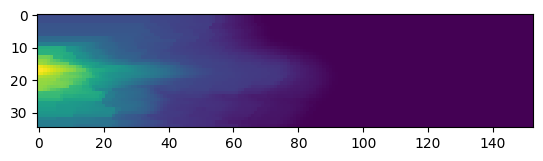

In [73]:
plt.imshow(numpy.max(numpy.array(pruned_alpha_set), axis=0).reshape(env_shape))

In [24]:
from tqdm import tqdm

In [47]:
alpha_set = fsvi_solution
pruned_alpha_set = []
for alpha_vector in tqdm(alpha_set.alpha_vector_list):
    dominated = False
    for compare_alpha_vector in pruned_alpha_set:
        if all(alpha_vector.values <= compare_alpha_vector.values):
            dominated = True
            break
    if not dominated:
        pruned_alpha_set.append(alpha_vector)

  4%|▍         | 37/980 [00:49<21:05,  1.34s/it]


KeyboardInterrupt: 

In [31]:
len(pruned_alpha_set)

980

In [34]:
import numpy

In [43]:
def dominates(a, b):
    return (a <= b).all()

In [36]:
a = np.asnumpy(fsvi_solution.alpha_vector_array)

In [50]:
from scipy.spatial.distance import cdist
X = cdist(a, a, metric=dominates).astype(bool)
rulers = numpy.where(not X.any(axis=1))[0]
if rulers.size > 0:
    rs = [a[i] for i in rulers]
else: # no one dominates every other
    rs = a

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [55]:
X

array([[ True, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [66]:
np.unique(np.argmax(fsvi_solution.alpha_vector_array, axis=1))

array([   0, 2142, 2295, 2448, 2449, 2452, 2453, 2454, 2455, 2456, 2601,
       2603, 2604, 2607, 2608, 2754, 2755, 2756, 2757, 2758, 2907, 2908,
       2909, 2910, 2915, 3060, 3061, 3062, 3063, 3064, 3213, 3214, 3215,
       3216, 3217, 3366, 3368, 3369, 3521, 3522], dtype=int64)

In [63]:
numpy.invert(X).all(axis=1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [45]:
X

array([[ True, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [46]:
rulers

array([1], dtype=int64)

In [ ]:
non_dominated = np.where(X.all(axis=1))[0]


In [20]:
fsvi_solution.prune(level=2)

TypeError: 'ValueFunction' object is not iterable

In [26]:
import numpy
numpy.max(res, axis=0).reshape(env_shape)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
[len(bs.belief_list) for bs in hist.belief_sets]

[1, 103, 44, 24, 110, 128]

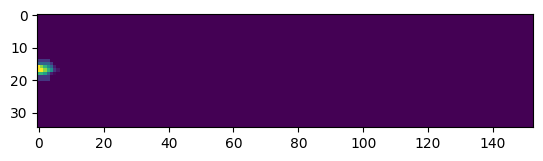

In [32]:
plt.imshow(numpy.max(res, axis=0).reshape(env_shape))

In [18]:
fsvi_solution.plot()

TypeError: list indices must be integers or slices, not ndarray

In [18]:
import sys
t = np.zeros((500000,2000))

In [20]:
t.nbytes

8000000000

In [22]:
8000000000 / 1024 / 1024 / 1024

7.450580596923828

TypeError: list indices must be integers or slices, not ndarray

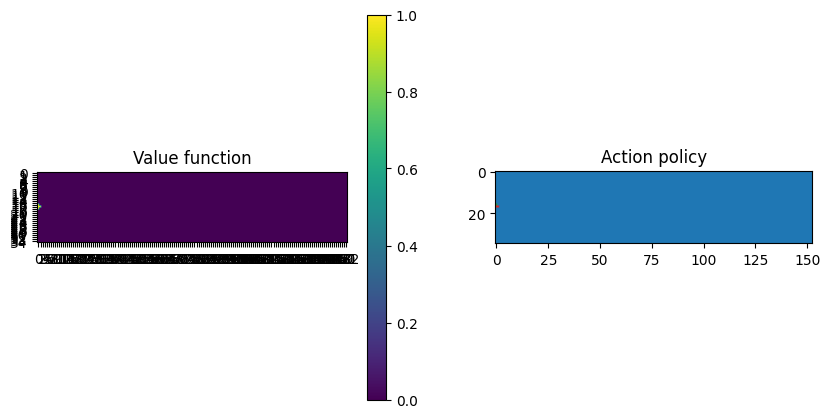

In [35]:
fsvi_solution.plot()

## Experiments

In [11]:
b = Belief(model)
belief_set = np.array([b])
belief_set = belief_set.repeat(80,axis=0)

In [12]:
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions] * 20).alpha_vector_array

In [13]:
gamma = 0.99
gamma_a_o_t = gamma * np.einsum('saor,vsar->aovs', model.reachable_transitional_observation_table, value_function[np.arange(value_function.shape[0])[:,None,None,None], model.reachable_states[None,:,:,:]])

In [14]:
best_alpha_ind = np.argmax(np.tensordot(belief_set, gamma_a_o_t, (1,3)), axis=3)

In [16]:
best_alpha_ind.shape

(80, 4, 2)

In [17]:
gamma_a_o_t.shape

(4, 2, 80, 5355)

In [18]:
import numpy.ma as ma

In [ ]:
ma.array()

In [31]:
(*best_alpha_ind.shape, model.state_count)

(80, 4, 2, 416000)

In [33]:
best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
for x in it:
    (b,a,o) = it.multi_index
    best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

In [34]:
best_alphas_per_o_2 = gamma_a_o_t[model.actions[None,:,None,None], model.observations[None,None,:,None], best_alpha_ind[:,:,:,None], model.states[None,None,None,:]]

In [38]:
best_alphas_per_o_2 = gamma_a_o_t[:,:,best_alpha_ind[:,:,:,None],:]

In [39]:
np.argwhere(best_alphas_per_o != best_alphas_per_o_2)

ValueError: operands could not be broadcast together with shapes (80,4,2,416000) (4,2,80,4,2,1,416000) 

In [59]:
# Reworked 2
def t3():
    best_alpha_ind = np.argmax(np.tensordot(beliefs, gamma_a_o_t, (1,3)), axis=3)

    best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
    it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
    for x in it:
        (b,a,o) = it.multi_index
        best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

    alpha_a = np.sum(best_alphas_per_o, axis=2)
    alpha_a += model.expected_rewards_table.T

    new_value_function = np.zeros(beliefs.shape)
    for i, b in enumerate(beliefs):
        best_ind = np.argmax(np.dot(alpha_a[i,:,:], b))
        new_value_function[i,:] = alpha_a[i, best_ind,:]

In [60]:
%timeit t3()

950 ms ± 69.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# Reworked
def t2():
    best_alpha_ind = np.argmax(np.dot(beliefs, gamma_a_o_t.swapaxes(3,2)), axis=3)

    best_alphas_per_o = np.zeros((*best_alpha_ind.shape, model.state_count))
    it = np.nditer(best_alpha_ind, flags=['multi_index'], op_flags=['readonly'])
    for x in it:
        (b,a,o) = it.multi_index
        best_alphas_per_o[b,a,o,:] = gamma_a_o_t[a,o,x,:]

    alpha_a = np.sum(best_alphas_per_o, axis=2)
    alpha_a += model.expected_rewards_table.T

    new_value_function = np.zeros(beliefs.shape)
    for i, b in enumerate(beliefs):
        best_ind = np.argmax(np.dot(alpha_a[i,:,:], b))
        new_value_function[i,:] = alpha_a[i, best_ind,:]

In [32]:
%timeit t2()

34.8 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def t1():
    for b in beliefs:
        best_alpha = None
        best_alpha_val = -np.inf

        for a in model.actions:
            
            obs_alpha_sum = np.zeros(model.state_count)
            
            for o in model.observations:
                
                # Argmax of alphas
                best_alpha_o = np.zeros(model.state_count)
                best_alpha_o_val = -np.inf
                
                for alpha_o in gamma_a_o_t[a][o]:
                    val = np.dot(alpha_o, b)
                    if val > best_alpha_o_val:
                        best_alpha_o_val = val
                        best_alpha_o = alpha_o
                        
                # Sum of the alpha_obs vectors
                obs_alpha_sum += best_alpha_o

            alpha_a_vect = model.expected_rewards_table[:,a] + obs_alpha_sum

            # Step 3
            val = np.dot(alpha_a_vect, b)
            if val > best_alpha_val:
                best_alpha_val = val
                best_alpha = AlphaVector(alpha_a_vect, a)

In [24]:
%timeit t1()

3min 37s ± 3.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Solving timing

regular size

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [10]:
%timeit solver.backup(model, belief_set, value_function)

670 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


double size

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [9]:
%timeit solver.backup(model, belief_set, value_function)

45.9 s ± 618 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


regular size (reachable)

In [8]:
solver = PBVI_Solver(eps=10e-5)
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [9]:
%timeit solver.backup(model, belief_set, value_function)

2.57 ms ± 80.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Double size (reachable)

In [8]:
solver = PBVI_Solver(eps=10e-5)

In [10]:
value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
belief_set = [Belief(model)]

In [11]:
%timeit solver.backup(model, belief_set, value_function)

10.9 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Solving profiling

In [10]:
solver = PBVI_Solver(eps=10e-8)

In [11]:
# solution, history = solver.solve(model, 8, 8)

In [12]:
model.expected_rewards_table.shape

(416000, 4)

In [13]:
from cProfile import Profile
from pstats import SortKey, Stats


with Profile() as profile:
    solver.solve(model, 4, 8)
    print(f"")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/4 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/8 [00:00<?, ?it/s]


         203339 function calls (193847 primitive calls) in 8.496 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17804    0.005    0.000    0.009    0.000 {built-in method builtins.isinstance}
10089/10007    0.002    0.000    0.002    0.000 {built-in method builtins.len}
8772/5677    0.003    0.000    0.033    0.000 traitlets.py:692(__get__)
7190/5170    0.004    0.000    0.031    0.000 traitlets.py:654(get)
     6924    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
6643/4388    0.004    0.000    0.029    0.000 {built-in method builtins.getattr}
     5767    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
     3778    0.006    0.000    0.012    0.000 numeric.py:1855(isscalar)
     3384    0.002    0.000    0.002    0.000 {built-in method builtins.hasattr}
     2881    0.001    0.000    0.001    0.000 {method 'endswith' of 'str' objects}
     2726    0.000    0.000    0.000    0.000

: 

In [25]:
import os
print(os.environ["TEMP"])

C:\Users\arnau\AppData\Local\Temp


In [13]:
from cProfile import Profile
from pstats import SortKey, Stats


with Profile() as profile:
    solver.solve(model, 4, 8)
    print(f"")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/4 [00:00<?, ?it/s]

Backups 0:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 1:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 2:   0%|          | 0/8 [00:00<?, ?it/s]

Backups 3:   0%|          | 0/8 [00:00<?, ?it/s]


         103472 function calls (95474 primitive calls) in 18.502 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
10170/7075    0.004    0.000    0.035    0.000 traitlets.py:692(__get__)
     8798    0.002    0.000    0.002    0.000 {built-in method builtins.isinstance}
8504/6484    0.004    0.000    0.031    0.000 traitlets.py:654(get)
6515/4260    0.003    0.000    0.029    0.000 {built-in method builtins.getattr}
     4066    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
     3248    0.002    0.000    0.002    0.000 {built-in method builtins.hasattr}
2710/2707    0.001    0.000    0.001    0.000 {built-in method builtins.len}
     2134    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
     1780    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
     1725    0.000    0.000    0.000    0.000 traitlets.py:263(__init__)
     1725    0.000    0.000    0.000    0.000 t